# Cropping function

_Author: Dan Shaked-Renous_
<br><br>

### Description:
In this notebook we developed the functions for cropping the weld images as close as possible to the weld's region of interest (ROI).<br>
Our approach uses a binary filter with an automated threshold. The binary image is projected on its two axes, and the cropping edges are selected.

### Conclusion
This method was very useful for selection of the weld ROI and was used also in the detection of the text/scale bar ROI.

In [1]:

import os
from os import listdir
from os.path import isfile, join
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from skimage import io
from skimage.color import rgb2gray
import statistics
from skimage import filters as flt
from skimage.segmentation import watershed
from skimage.filters import sobel
from scipy import ndimage as ndi


from scipy.signal import find_peaks
from scipy.signal import savgol_filter

In [3]:
# Add /scr/data folder to your system path
sys.path.append(os.pardir + '/src/data')

import segment_image as si
from segment_image import is_RGB

In [ ]:
"""
Crops the image according to x and y profile-histograms.

Parameters
----------
binary : ndarray
    Binary image array.

Returns
-------
binary_cropped
    Cropped binary image array.
"""

In [29]:
fname = '../data/interim/merged_data/not_measured/1M-A31N_10x.jpg' #9L-59_10x.jpg'
image = io.imread(fname)

In [30]:
gray = rgb2gray(image)
# blurred_image = flt.gaussian(gray)
thresh = si.get_threshold(gray, norm=False)

In [8]:
import importlib
importlib.reload(si)

<module 'segment_image' from '../src/data/segment_image.py'>

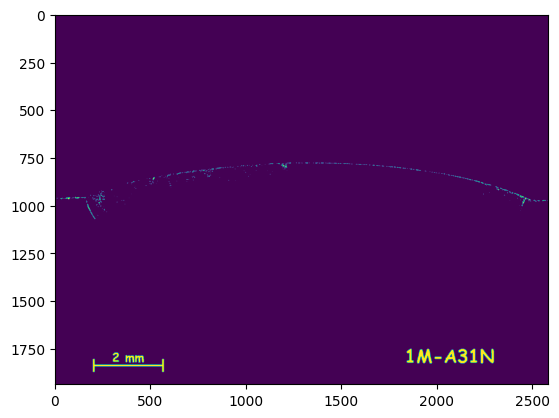

In [31]:
# cropping the scale bar and the text
binary = si.threshold_binary(gray, .95)
plt.imshow(binary)
plt.show()

In [32]:
# Creating the histograms in y axis
histo = np.where(binary)
y = np.histogram(histo[0], bins=binary.shape[0], range=(0,binary.shape[0]))

y_edge = int(y[1][np.where(y[0] > 150)].min())

Plotting the projection on the y-axis

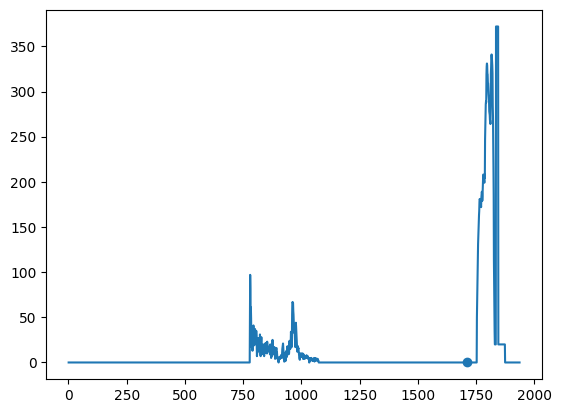

In [33]:
plt.plot(y[1][1:],y[0])
plt.scatter(y_edge-50, 0)

In [141]:
def locate_text_y(input: np.ndarray) -> int:
    """Locating the text region.

    Args:
        input (np.ndarray): input image

    Returns:
        int: the y coordinate of the top of the text region in an image.
    """
    #conversion to grayscale i image is  RBG
    if is_RGB(input):
            input = rgb2gray(input)
    # Filtering text region 
    binary = si.threshold_binary(input, .95)
    
    # Creating the histograms in y axis
    histo = np.where(binary)
    y = np.histogram(histo[0], bins=binary.shape[0], range=(0,binary.shape[0]))
    y_edge = int(y[1][np.where(y[0] > 150)].max() - 200)
    return y_edge-50

In [35]:
def cut_scale_off(input: np.ndarray) -> np.ndarray:
    return input[:locate_text_y(input)]

In [36]:
locate_text_y(image)

1710

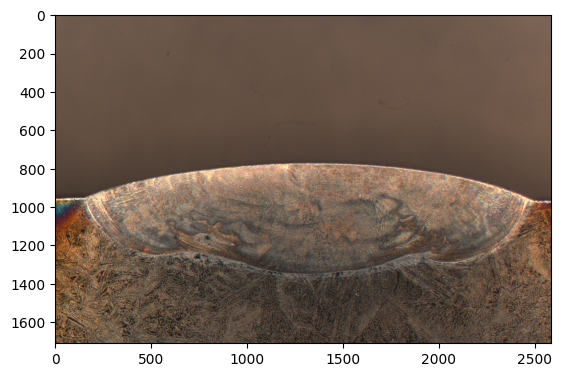

In [37]:
plt.imshow(image[:locate_text_y(image)])

In [38]:
gray = rgb2gray(image[:locate_text_y(image)])

In [39]:
blurred_image = flt.gaussian(gray, sigma=5)

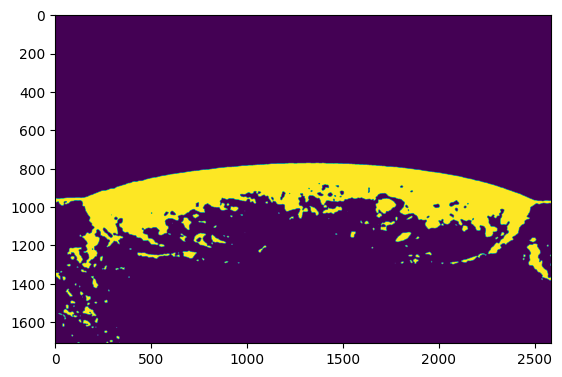

In [40]:
binary = si.threshold_binary(blurred_image, thresh)
plt.imshow(binary)

In [45]:
def profile_hist(binary: np.ndarray) -> tuple:
    histo = np.where(binary)
    x = np.histogram(histo[1], bins=binary.shape[1], range=(0,binary.shape[1]))
    y = np.histogram(histo[0], bins=binary.shape[0], range=(0,binary.shape[0]))
    return x, y
   

In [41]:
# Creating the histograms in both dimensions
x, y = hist_profile(binary)

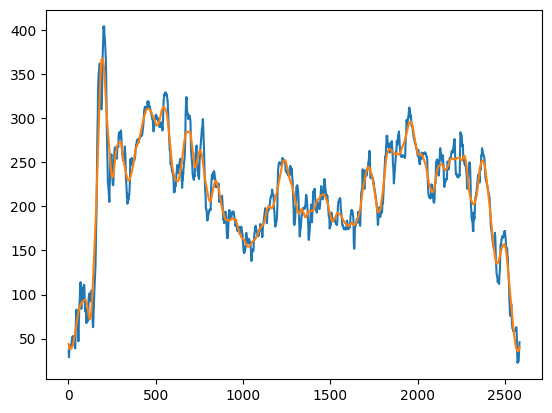

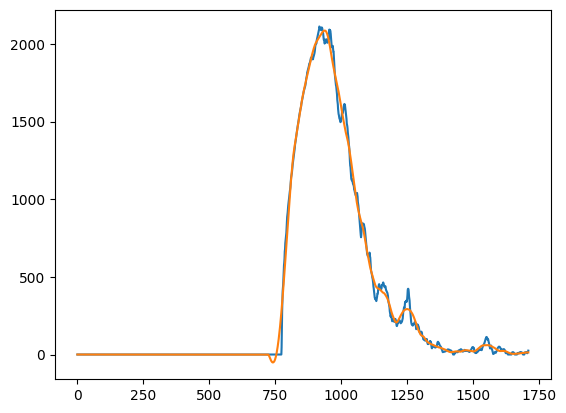

In [51]:
plt.plot(x[1][1:],x[0])
plt.plot(x[1][1:],savgol_filter(x[0],101,3))
plt.show()
plt.plot(y[1][1:],y[0])
plt.plot(y[1][1:],savgol_filter(y[0],101,3))
plt.show()

In [52]:
y_smooth = savgol_filter(y[0],101,3)

In [53]:
y_edges = []
y_edges.append((int(y[1][np.where(y_smooth > 50)].min()), int(y[1][np.where(y_smooth > 50)].max())))
y_edges.append((y[0][np.where(y[1] == y_edges[0][0])], y[0][np.where(y[1] == y_edges[0][1])]))

In [54]:
buffer_y = 50
y_edges_buff = []
y_edges_buff.append((y_edges[0][0] - buffer_y, y_edges[0][1] + buffer_y))
y_edges_buff.append((y[0][np.where(y[1] == y_edges_buff[0][0])], y[0][np.where(y[1] == y_edges_buff[0][1])]))

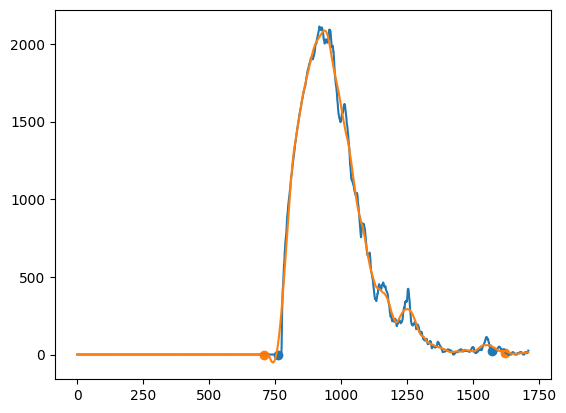

In [55]:
plt.plot(y[1][1:],y[0])
plt.plot(y[1][1:],savgol_filter(y[0],101,3))
plt.scatter(y_edges[0], y_edges[1])
plt.scatter(y_edges_buff[0], y_edges_buff[1])
plt.show()

We managed to extract edges along the y axis.<br>
Now we can crop andsearch for the edges along the x-axis.

In [56]:
y_edges[0]

(760, 1573)

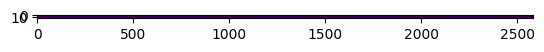

In [57]:
cropped_along_y = binary_scale_cropped[int(y_edges_buff[0][0]):int(y_edges_buff[0][1])]
plt.imshow(cropped_along_y)

Now we can project again the histogram to the x-axis

In [172]:
# Creating the histograms in both dimensions
histo = np.where(cropped_along_y)
x = np.histogram(histo[1], bins=cropped_along_y.shape[1], range=(0,cropped_along_y.shape[1]))
y = np.histogram(histo[0], bins=cropped_along_y.shape[0], range=(0,cropped_along_y.shape[0]))

In [173]:
x_smooth = savgol_filter(x[0],101,3)

In [174]:
# Dividing image along x into 'right' and 'left' buckets
cutoff = cropped_along_y.shape[1]//2
x_smooth_L = x[0][:cutoff]
x_smooth_R = x[0][cutoff:]

In [175]:
x_edges = []
x_edges.append((int(x[1][np.where(x_smooth_L == x_smooth_L.min())][0]),
                int(x[1][np.where(x_smooth_R == x_smooth_R.min())][0])+ cutoff))
x_edges.append((x[0][np.where(x[1] == x_edges[0][0])], 
                x[0][np.where(x[1] == x_edges[0][1])]))

In [180]:
buffer_x = 50
x_edges_buff = []
x_edges_buff.append((np.max([0, x_edges[0][0] - buffer_x]),
                     np.min([cropped_along_y.shape[1]-1, x_edges[0][1] + buffer_x])))
x_edges_buff.append((x[0][np.where(y[1] == x_edges_buff[0][0])], x[0][np.where(x[1] == x_edges_buff[0][1])]))

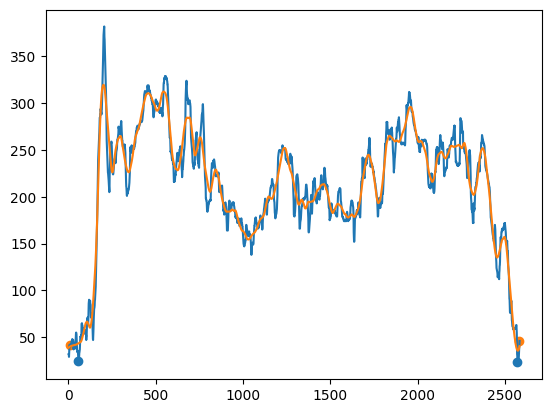

In [181]:
plt.plot(x[1][1:],x[0])
plt.plot(x[1][1:],savgol_filter(x[0],101,3))
plt.scatter(x_edges[0], x_edges[1])
plt.scatter(x_edges_buff[0], x_edges_buff[1])
plt.show()

In [49]:
cropped_along_x = cropped_along_y[:,int(x_edges_buff[0][0]):int(x_edges_buff[0][1])]
plt.imshow(cropped_along_x)

NameError: name 'cropped_along_y' is not defined

In [109]:
def crop_image_y(binary: np.ndarray,    threshold: int = 50) -> tuple:
    """Crops the image according to y profile-histograms.

    Args:
        binary (np.ndarray): a binary image without the scale region
        threshold (int): a threshold for the ROI edge detection.

    Returns:
        cropped_along_y: a binary image cropped along the y-axis
        y_edges_buff: the cropping edges with respect to the sape of the input binary
    """

    _, y = profile_hist(binary)
    
    # Identify cropping edges along the y axis
        
    y_smooth = savgol_filter(y[0],101,3)
    y_edges = []
    y_edges.append((int(y[1][np.where(y_smooth > threshold)].min()), int(y[1][np.where(y_smooth > threshold)].max())))
    y_edges.append((y[0][np.where(y[1] == y_edges[0][0])], y[0][np.where(y[1] == y_edges[0][1])]))
    
    # adding a buffer in each side
    buffer_y = 50
    y_edges_buff = []
    y_edges_buff.append((np.max([0,y_edges[0][0] - buffer_y]),
                         np.min([y_edges[0][1] + buffer_y, binary.shape[0]-1])))
    y_edges_buff.append((y[0][np.where(y[1] == y_edges_buff[0][0])], y[0][np.where(y[1] == y_edges_buff[0][1])]))
    
    cropped_along_y = binary[int(y_edges_buff[0][0]):int(y_edges_buff[0][1])]
    
    return cropped_along_y, y_edges_buff

    

In [98]:
def crop_image_x(binary: np.ndarray) -> tuple:
    """Crops the image according to x profile-histograms.

    Args:
        binary (np.ndarray): a binary image without the scale region

    Returns:
        cropped_along_x: a binary image cropped along the x-axis
        x_edges_buff: the cropping edges with respect to the sape of the input binary
    """

    x, _ = profile_hist(binary)
    
    # Identify cropping edges along the y axis
        
    x_smooth = savgol_filter(x[0],101,3)
    
    # Dividing image along x into 'right' and 'left' buckets
    cutoff = cropped_along_y.shape[1]//2
    x_smooth_L = x[0][:cutoff]
    x_smooth_R = x[0][cutoff:]
    
    x_edges = []
    x_edges.append((int(x[1][np.where(x_smooth_L == x_smooth_L.min())][0]),
                    int(x[1][np.where(x_smooth_R == x_smooth_R.min())][0])+ cutoff))
    x_edges.append((x[0][np.where(x[1] == x_edges[0][0])], 
                    x[0][np.where(x[1] == x_edges[0][1])]))
    
    # adding a buffer in each side
    buffer_x = 50
    x_edges_buff = []
    x_edges_buff.append((np.max([0, x_edges[0][0] - buffer_x]),
                        np.min([binary.shape[1]-1, x_edges[0][1] + buffer_x])))
    x_edges_buff.append((x[0][np.where(y[1] == x_edges_buff[0][0])], x[0][np.where(x[1] == x_edges_buff[0][1])]))
    
    cropped_along_x = binary[:,int(x_edges_buff[0][0]):int(x_edges_buff[0][1])]
    return cropped_along_x, x_edges_buff

# The procedure for cropping

In [129]:
fname = '../data/interim/merged_data/not_measured/8x 4P-B2.jpg' #9L-59_10x.jpg'
image = io.imread(fname)

In [130]:
gray = rgb2gray(image)
thresh = si.get_threshold(gray, norm=False)

In [131]:
import importlib
importlib.reload(si)

<module 'segment_image' from '../src/data/segment_image.py'>

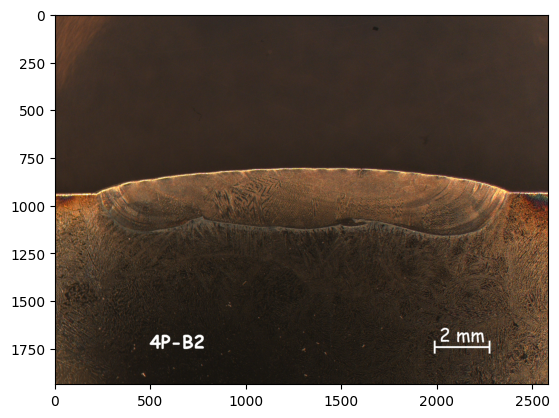

In [132]:
plt.imshow(image)

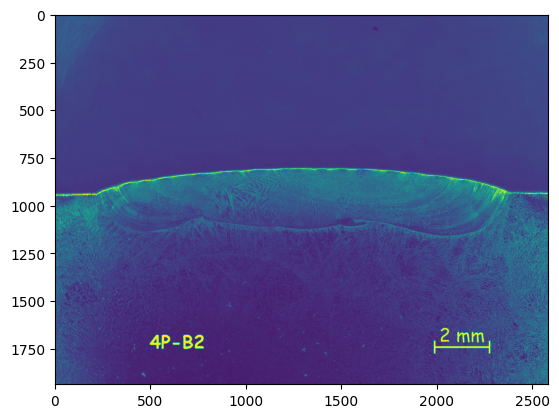

In [133]:
gray = rgb2gray(image)
plt.imshow(gray)

In [142]:
binary = si.threshold_binary(gray, .95)
histo = np.where(binary)
y = np.histogram(histo[0], bins=binary.shape[0], range=(0,binary.shape[0]))


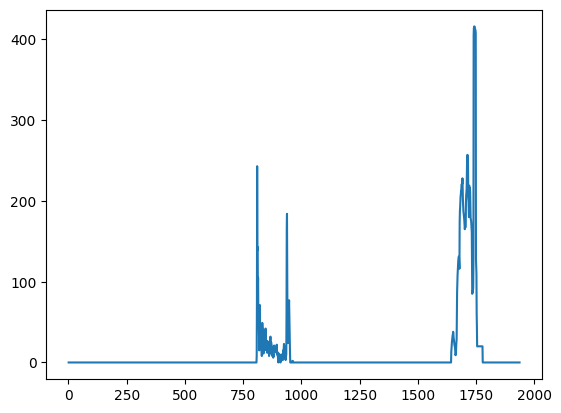

In [143]:
plt.plot(y[1][1:], y[0])

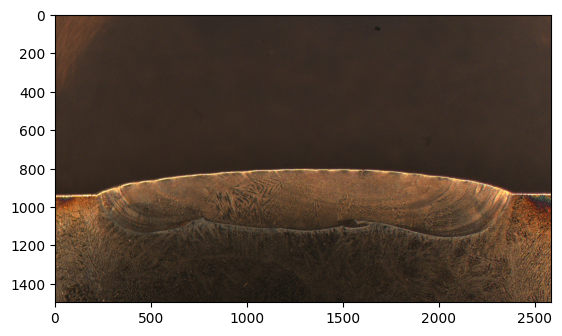

In [144]:
image_precrop = cut_scale_off(image)
plt.imshow(image_precrop)
plt.show()

In [145]:
gray = rgb2gray(image[:locate_text_y(image)])

In [146]:
blurred_image = flt.gaussian(gray, sigma=5)

In [147]:
binary = si.threshold_binary(blurred_image, thresh)

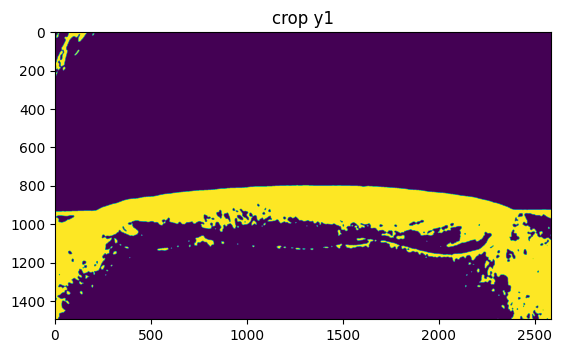

In [151]:
cropped_y1 = crop_image_y(binary)
plt.imshow(cropped_y1[0])
plt.title('crop y1')
plt.show()

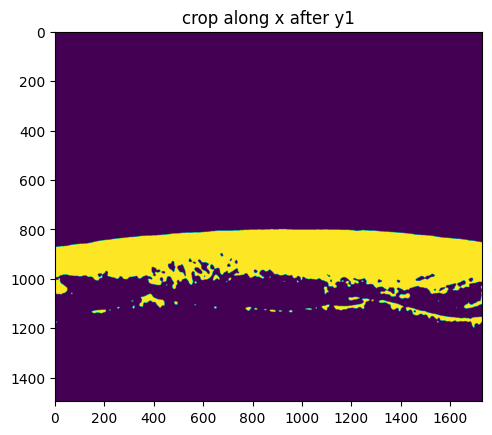

In [152]:
cropped_x = crop_image_x(cropped_y1[0])
plt.imshow(cropped_x[0])
plt.title('crop along x after y1')
plt.show()

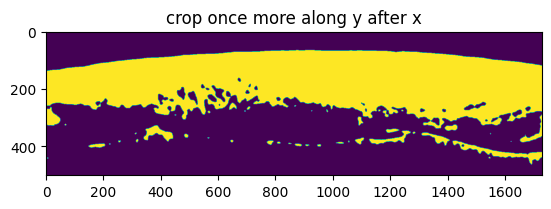

In [153]:
cropped_y2 = crop_image_y(cropped_x[0])
plt.imshow(cropped_y2[0])
plt.title('crop once more along y after x')
plt.show()